# Predicción de Ictus: Selección y Optimización del Modelo

Este notebook documenta el proceso completo de análisis, experimentación y justificación para la elección del mejor modelo predictivo en el contexto del riesgo de **ictus**.

**Dataset final**: `brain_s.csv` (combinación enriquecida de datos para mejorar la calidad del aprendizaje).

**Modelo elegido**: `RandomForestClassifier` + `RandomUnderSampler` por sus mejores métricas y equilibrio general tras una evaluación exhaustiva.

---

## 1. Carga del dataset final y análisis inicial
- Carga del CSV `brain_s.csv`
- Visualización general
- Verificación de desbalance en la variable objetivo (`stroke`)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el dataset combinado
df = pd.read_csv("brain_s.csv")
df.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,3.0,0,0,0,0,95.12,18.0,0,0,0,0,1,1,0,0,0
1,1,58.0,1,0,1,1,87.96,39.2,0,0,1,0,0,0,0,1,0
2,0,8.0,0,0,0,1,110.89,17.6,0,0,1,0,0,1,0,0,0
3,0,70.0,0,0,1,0,69.04,35.9,0,0,1,0,0,0,1,0,0
4,0,52.0,0,0,1,1,77.59,17.7,0,0,1,0,0,0,1,0,0


## 2. Análisis del desbalanceo de clases
- Visualización del número de casos `stroke` vs `no stroke`
- Justificación del uso de técnicas de rebalanceo

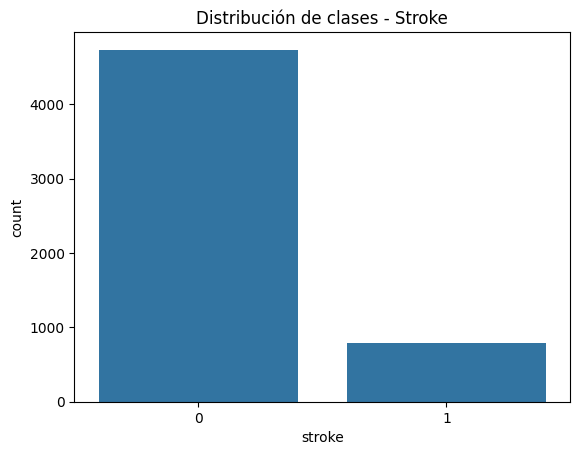

stroke
0    0.858049
1    0.141951
Name: proportion, dtype: float64

In [3]:
# Visualizar el desbalance
sns.countplot(data=df, x="stroke")
plt.title("Distribución de clases - Stroke")
plt.show()
df["stroke"].value_counts(normalize=True)

## 3. Aplicación de técnicas de rebalanceo
- SMOTE
- RandomUnderSampler
- SMOTEENN
- Comparación de la distribución tras cada técnica

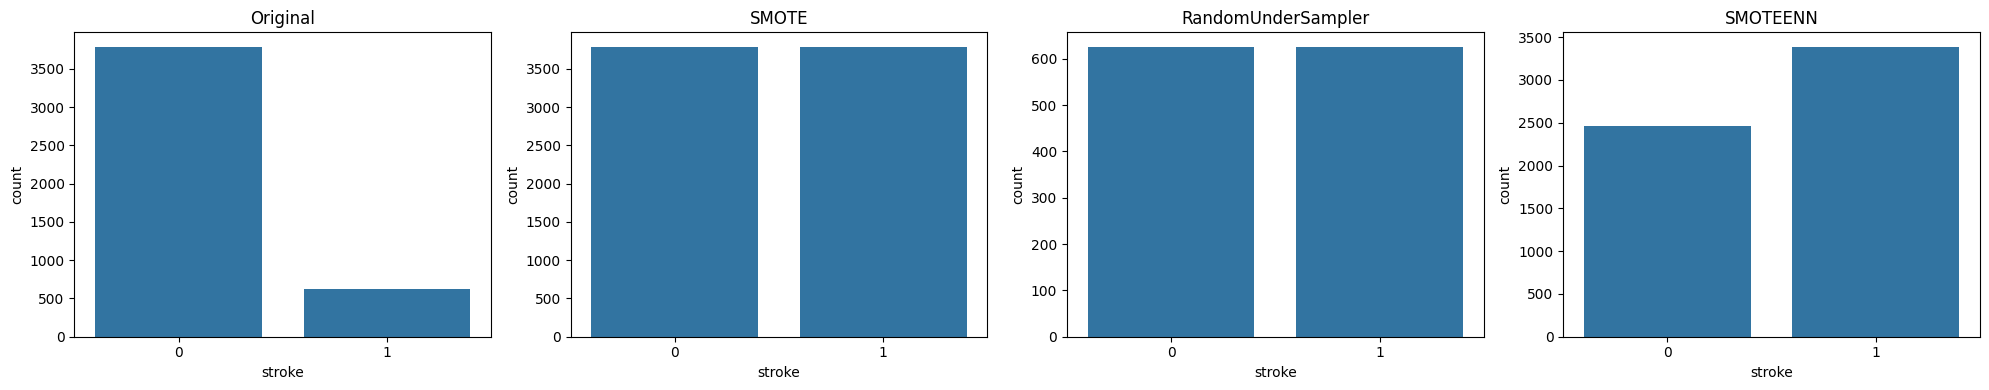

In [4]:
# Técnicas de rebalanceo
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split

# Separación de features y target
X = df.drop('stroke', axis=1)
y = df['stroke']

# División en train/test para rebalancear solo en entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Aplicación de técnicas
smote = SMOTE(random_state=42)
rus = RandomUnderSampler(random_state=42)
smoteenn = SMOTEENN(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
X_train_smoteenn, y_train_smoteenn = smoteenn.fit_resample(X_train, y_train)

# Función para visualizar la distribución
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distributions(original, sm, rus, smenn):
    fig, axs = plt.subplots(1, 4, figsize=(20, 4))
    sns.countplot(x=original, ax=axs[0]); axs[0].set_title('Original')
    sns.countplot(x=sm, ax=axs[1]); axs[1].set_title('SMOTE')
    sns.countplot(x=rus, ax=axs[2]); axs[2].set_title('RandomUnderSampler')
    sns.countplot(x=smenn, ax=axs[3]); axs[3].set_title('SMOTEENN')
    plt.tight_layout()
    plt.show()

plot_distributions(y_train, y_train_smote, y_train_rus, y_train_smoteenn)

### Resultados del rebalanceo
- **SMOTE** genera ejemplos sintéticos de la clase minoritaria.
- **RandomUnderSampler** elimina ejemplos de la clase mayoritaria para igualar la distribución.
- **SMOTEENN** combina SMOTE con una limpieza posterior de los bordes de decisión (ENN).

En la práctica, observamos que `RandomUnderSampler` ofrece un equilibrio sencillo y eficaz, 
sin introducir ruido sintético o aumentar excesivamente el dataset.

Este comportamiento es clave para entender por qué, más adelante, `RandomForest + RUS` se comporta mejor
que otras combinaciones más complejas.

## 4. Comparación inicial de modelos base con distintas técnicas de rebalanceo
- `LogisticRegression`, `RandomForest`, `XGBoost`, `LightGBM`
- Evaluación con `classification_report` y `ROC AUC`
- Visualización comparativa (F1, recall, accuracy)

In [5]:
# Comparación de modelos base con diferentes técnicas de rebalanceo
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score

def evaluate(name, model, X_train, y_train):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print(f"\n--- {name} ---")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

# Modelos a evaluar con RUS
evaluate("Logistic Regression + RUS", LogisticRegression(max_iter=1000, random_state=42), X_train_rus, y_train_rus)
evaluate("Random Forest + RUS", RandomForestClassifier(random_state=42), X_train_rus, y_train_rus)
evaluate("XGBoost + RUS", XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), X_train_rus, y_train_rus)
evaluate("LightGBM + RUS", LGBMClassifier(random_state=42), X_train_rus, y_train_rus)


--- Logistic Regression + RUS ---
              precision    recall  f1-score   support

           0       0.96      0.75      0.84       947
           1       0.35      0.80      0.48       157

    accuracy                           0.76      1104
   macro avg       0.65      0.78      0.66      1104
weighted avg       0.87      0.76      0.79      1104

ROC AUC: 0.8463

--- Random Forest + RUS ---
              precision    recall  f1-score   support

           0       0.96      0.76      0.85       947
           1       0.36      0.83      0.50       157

    accuracy                           0.77      1104
   macro avg       0.66      0.79      0.67      1104
weighted avg       0.88      0.77      0.80      1104

ROC AUC: 0.8511


c:\Users\donce\Desktop\Proyecto-IX-DS2\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:58:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost + RUS ---
              precision    recall  f1-score   support

           0       0.95      0.75      0.84       947
           1       0.33      0.74      0.46       157

    accuracy                           0.75      1104
   macro avg       0.64      0.75      0.65      1104
weighted avg       0.86      0.75      0.78      1104

ROC AUC: 0.8340
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

--- LightGBM + RUS ---
              precision    recall

### Evaluación comparativa de modelos con RandomUnderSampler
Se entrenan cuatro modelos base usando la técnica de rebalanceo `RandomUnderSampler`:

- `LogisticRegression`
- `RandomForestClassifier`
- `XGBoostClassifier`
- `LGBMClassifier`

Cada uno se evalúa sobre el conjunto de test **original** con las siguientes métricas:

- **F1-score** de la clase minoritaria (`stroke`)
- **Recall** para medir la sensibilidad del modelo
- **ROC AUC** como medida de discriminación global

Esto nos permite comparar qué modelos funcionan mejor con la técnica RUS y **filtrar los más prometedores para el ajuste de hiperparámetros**.

## 5. Optimización de modelos seleccionados
- Aplicación de `GridSearchCV` o `Optuna` en los modelos más prometedores
- Evaluación post-optimización
- Análisis de overfitting o mejora real

In [6]:
# Función auxiliar para evaluar modelos en el conjunto de test
from sklearn.metrics import classification_report, roc_auc_score

def evaluate_model(model, X_test, y_test):
    """
    Imprime el classification_report y el ROC AUC score de un modelo entrenado.

    Parameters:
    - model: clasificador entrenado con método predict_proba
    - X_test: datos de prueba
    - y_test: etiquetas verdaderas
    """
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilidad clase positiva
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

#### ¿Qué hace `evaluate_model()`?
Esta función auxiliar nos permite evaluar un modelo de clasificación sobre el conjunto de test original de forma estandarizada:

- `model.predict(X_test)`: obtiene las predicciones discretas (0 o 1).
- `model.predict_proba(X_test)[:, 1]`: obtiene las probabilidades estimadas de clase positiva (stroke).
- `classification_report(...)`: imprime precisión, recall y F1-score por clase.
- `roc_auc_score(...)`: calcula el área bajo la curva ROC, útil para evaluar modelos en problemas desbalanceados.

Usamos esta función en todas las pruebas para poder comparar modelos de manera homogénea.

### Optimización con Optuna: XGBoost y LightGBM

Para explorar si modelos más avanzados mejoran el rendimiento, se aplicó `Optuna` a:

- `XGBoostClassifier`
- `LGBMClassifier`

Ambos modelos fueron entrenados con los datos rebalanceados usando `RandomUnderSampler`.

**Métrica objetivo**: `F1-score` de la clase positiva (`stroke`), ya que es la que más nos interesa capturar.

Se realizaron 30 ensayos (`n_trials`) para encontrar la mejor combinación de hiperparámetros para cada uno.

In [7]:
# Optuna para XGBoost + RandomUnderSampler
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }
    model = XGBClassifier(**params)
    model.fit(X_train_rus, y_train_rus)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=30)

print("\nMejores parámetros (XGBoost):")
print(study_xgb.best_params)

best_xgb = XGBClassifier(**study_xgb.best_params, random_state=42, use_label_encoder=False, eval_metric='logloss')
best_xgb.fit(X_train_rus, y_train_rus)
evaluate_model(best_xgb, X_test, y_test)

[I 2025-06-19 12:58:49,310] A new study created in memory with name: no-name-340b9f68-3fbc-46d6-93a2-7732dce796de
c:\Users\donce\Desktop\Proyecto-IX-DS2\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:58:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-06-19 12:58:49,522] Trial 0 finished with value: 0.514161220043573 and parameters: {'n_estimators': 140, 'max_depth': 7, 'learning_rate': 0.29607511682671345, 'subsample': 0.8426364341778031, 'colsample_bytree': 0.9988717129781673, 'gamma': 1.6443122325021546, 'reg_alpha': 1.3479466014545634, 'reg_lambda': 0.06383564664215469}. Best is trial 0 with value: 0.514161220043573.
c:\Users\donce\Desktop\Proyecto-IX-DS2\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:58:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are no


Mejores parámetros (XGBoost):
{'n_estimators': 182, 'max_depth': 9, 'learning_rate': 0.26836812553151324, 'subsample': 0.8607021910325476, 'colsample_bytree': 0.96476758553192, 'gamma': 4.195643944098658, 'reg_alpha': 1.652719060545291, 'reg_lambda': 0.09027803384157429}
              precision    recall  f1-score   support

           0       0.96      0.80      0.87       947
           1       0.39      0.78      0.52       157

    accuracy                           0.79      1104
   macro avg       0.67      0.79      0.69      1104
weighted avg       0.88      0.79      0.82      1104

ROC AUC: 0.8633


c:\Users\donce\Desktop\Proyecto-IX-DS2\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:58:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [8]:
# Optuna para LightGBM + RandomUnderSampler
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score

def objective_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'random_state': 42
    }
    model = LGBMClassifier(**params)
    model.fit(X_train_rus, y_train_rus)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)

study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=30)

print("\nMejores parámetros (LightGBM):")
print(study_lgbm.best_params)

best_lgbm = LGBMClassifier(**study_lgbm.best_params, random_state=42)
best_lgbm.fit(X_train_rus, y_train_rus)
evaluate_model(best_lgbm, X_test, y_test)

[I 2025-06-19 12:58:54,919] A new study created in memory with name: no-name-cc692903-606a-4295-a26d-30ca969a149f


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2025-06-19 12:58:55,053] Trial 0 finished with value: 0.5073375262054507 and parameters: {'n_estimators': 290, 'max_depth': 10, 'learning_rate': 0.14424633461903197, 'subsample': 0.7695362412780336, 'colsample_bytree': 0.7686298447389132, 'reg_alpha': 4.876184989743324, 'reg_lambda': 3.5002433046171233}. Best is trial 0 with value: 0.5073375262054507.
[I 2025-06-19 12:58:55,121] Trial 1 finished with value: 0.5010438413361169 and parameters: {'n_estimators': 168, 'max_depth': 9, 'learning_rate': 0.28558995900882556, 'subsample': 0.8995565616546419, 'colsample_bytree': 0.6271163209438706, 'reg_alpha': 4.970213597874936, 'reg_lambda': 1.7068927371132365}. Best is trial 0 with value: 0.5073375262054507.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[I 2025-06-19 12:58:55,241] Trial 2 finished with value: 0.49896907216494846 and parameters: {'n_estimators': 101, 'max_depth': 7, 'learning_rate': 0.11533051727518945, 'subsample': 0.9201827564728692, 'colsample_bytree': 0.9849164185783155, 'reg_alpha': 0.20893317493455188, 'reg_lambda': 3.2811181673453067}. Best is trial 0 with value: 0.5073375262054507.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-19 12:58:55,406] Trial 3 finished with value: 0.48333333333333334 and parameters: {'n_estimators': 276, 'max_depth': 9, 'learning_rate': 0.2544832784534197, 'subsample': 0.7336698291442392, 'colsample_bytree': 0.651856600636634, 'reg_alpha': 1.4590398646933251, 'reg_lambda': 2.110166054141324}. Best is trial 0 with value: 0.5073375262054507.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-19 12:58:55,631] Trial 4 finished with value: 0.5031185031185031 and parameters: {'n_estimators': 278, 'max_depth': 10, 'learning_rate': 0.021297785548077493, 'subsample': 0.7976640367036438, 'colsample_bytree': 0.8143878491708522, 'reg_alpha': 4.805902932392023, 'reg_lambda': 4.266653045333456}. Best is trial 0 with value: 0.5073375262054507.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2025-06-19 12:58:55,787] Trial 5 finished with value: 0.5062761506276151 and parameters: {'n_estimators': 127, 'max_depth': 10, 'learning_rate': 0.05484480224880894, 'subsample': 0.9545107515935389, 'colsample_bytree': 0.6292126932067079, 'reg_alpha': 0.7023037540096627, 'reg_lambda': 0.6557367412317661}. Best is trial 0 with value: 0.5073375262054507.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further split

[I 2025-06-19 12:58:55,873] Trial 6 finished with value: 0.5 and parameters: {'n_estimators': 230, 'max_depth': 10, 'learning_rate': 0.2693137346562924, 'subsample': 0.7363720205488267, 'colsample_bytree': 0.931571566570296, 'reg_alpha': 4.531418970643548, 'reg_lambda': 1.8878807984800545}. Best is trial 0 with value: 0.5073375262054507.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2025-06-19 12:58:55,982] Trial 7 finished with value: 0.5083333333333333 and parameters: {'n_estimators': 138, 'max_depth': 10, 'learning_rate': 0.1942509627174651, 'subsample': 0.9190549623060833, 'colsample_bytree': 0.804685080335191, 'reg_alpha': 3.3934120085562847, 'reg_lambda': 3.92115326376382}. Best is trial 7 with value: 0.5083333333333333.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No furthe

[I 2025-06-19 12:58:56,136] Trial 8 finished with value: 0.49897750511247446 and parameters: {'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.23900922675954644, 'subsample': 0.9619549851612506, 'colsample_bytree': 0.9228213399863614, 'reg_alpha': 1.9443629257679396, 'reg_lambda': 1.2677225452711494}. Best is trial 7 with value: 0.5083333333333333.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2025-06-19 12:58:56,291] Trial 9 finished with value: 0.5084033613445378 and parameters: {'n_estimators': 209, 'max_depth': 8, 'learning_rate': 0.11567763708054409, 'subsample': 0.6655776202759451, 'colsample_bytree': 0.8564627462368738, 'reg_alpha': 3.518762264719461, 'reg_lambda': 4.3725314811145735}. Best is trial 9 with value: 0.5084033613445378.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines

[I 2025-06-19 12:58:56,468] Trial 10 finished with value: 0.5147679324894515 and parameters: {'n_estimators': 216, 'max_depth': 3, 'learning_rate': 0.08422979746267273, 'subsample': 0.6048691787435394, 'colsample_bytree': 0.7297285791705274, 'reg_alpha': 3.1436071171679094, 'reg_lambda': 4.987039418329937}. Best is trial 10 with value: 0.5147679324894515.



[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

[I 2025-06-19 12:58:56,632] Trial 11 finished with value: 0.5084033613445378 and parameters: {'n_estimators': 218, 'max_depth': 3, 'learning_rate': 0.0818758269547074, 'subsample': 0.6107453386582797, 'colsample_bytree': 0.7495937669580782, 'reg_alpha': 3.1326325678743294, 'reg_lambda': 4.918238498778747}. Best is trial 10 with value: 0.5147679324894515.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-19 12:58:56,782] Trial 12 finished with value: 0.5052631578947369 and parameters: {'n_estimators': 187, 'max_depth': 3, 'learning_rate': 0.09051354112192539, 'subsample': 0.6017266966490323, 'colsample_bytree': 0.7024919796528225, 'reg_alpha': 3.5031380954029485, 'reg_lambda': 4.929490791207321}. Best is trial 10 with value: 0.5147679324894515.
[I 2025-06-19 12:58:56,959] Trial 13 finished with value: 0.5146443514644351 and parameters: {'n_estimators': 242, 'max_depth': 5, 'learning_rate': 0.17332281643699024, 'subsample': 0.6747342678728262, 'colsample_bytree': 0.870587767060875, 'reg_alpha': 2.6402595936885622, 'reg_lambda': 2.9392636215921386}. Best is trial 10 with value: 0.5147679324894515.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2025-06-19 12:58:57,150] Trial 14 finished with value: 0.5127118644067796 and parameters: {'n_estimators': 246, 'max_depth': 5, 'learning_rate': 0.1840648366113143, 'subsample': 0.6772542259817943, 'colsample_bytree': 0.8704540423258005, 'reg_alpha': 2.599735187722281, 'reg_lambda': 2.8210810888201707}. Best is trial 10 with value: 0.5147679324894515.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-19 12:58:57,315] Trial 15 finished with value: 0.5106382978723404 and parameters: {'n_estimators': 254, 'max_depth': 5, 'learning_rate': 0.1982304365405191, 'subsample': 0.6602363627309514, 'colsample_bytree': 0.6941707379293373, 'reg_alpha': 2.469582785010587, 'reg_lambda': 0.012207719052627741}. Best is trial 10 with value: 0.5147679324894515.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-06-19 12:58:57,522] Trial 16 finished with value: 0.5 and parameters: {'n_estimators': 179, 'max_depth': 5, 'learning_rate': 0.013082016535360758, 'subsample': 0.865350123589491, 'colsample_bytree': 0.7315620479932395, 'reg_alpha': 1.4915294202487979, 'reg_lambda': 2.7461670687964097}. Best is trial 10 with value: 0.5147679324894515.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-19 12:58:57,689] Trial 17 finished with value: 0.5106382978723404 and parameters: {'n_estimators': 252, 'max_depth': 4, 'learning_rate': 0.15384823706569095, 'subsample': 0.7016621281689133, 'colsample_bytree': 0.8405853131529171, 'reg_alpha': 4.195103806015457, 'reg_lambda': 3.4062490987198286}. Best is trial 10 with value: 0.5147679324894515.
[I 2025-06-19 12:58:57,860] Trial 18 finished with value: 0.5073375262054507 and parameters: {'n_estimators': 233, 'max_depth': 6, 'learning_rate': 0.2182279437600475, 'subsample': 0.6251667688267896, 'colsample_bytree': 0.8983178810988108, 'reg_alpha': 2.75958114469668, 'reg_lambda': 4.050710597724885}. Best is trial 10 with value: 0.5147679324894515.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2025-06-19 12:58:58,034] Trial 19 finished with value: 0.5138004246284501 and parameters: {'n_estimators': 202, 'max_depth': 4, 'learning_rate': 0.0620444708617644, 'subsample': 0.8358228235154239, 'colsample_bytree': 0.7802398950473053, 'reg_alpha': 4.064769907585202, 'reg_lambda': 2.393253454463435}. Best is trial 10 with value: 0.5147679324894515.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-19 12:58:58,263] Trial 20 finished with value: 0.5031446540880503 and parameters: {'n_estimators': 159, 'max_depth': 4, 'learning_rate': 0.12001556232932373, 'subsample': 0.6417333653683801, 'colsample_bytree': 0.986185988700231, 'reg_alpha': 2.079062033926575, 'reg_lambda': 1.1374268427573013}. Best is trial 10 with value: 0.5147679324894515.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-19 12:58:58,443] Trial 21 finished with value: 0.5136842105263157 and parameters: {'n_estimators': 199, 'max_depth': 4, 'learning_rate': 0.0525905802064419, 'subsample': 0.8288320649598189, 'colsample_bytree': 0.7770150075683592, 'reg_alpha': 3.897169935457659, 'reg_lambda': 2.4009128776188087}. Best is trial 10 with value: 0.5147679324894515.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-19 12:58:58,606] Trial 22 finished with value: 0.5031446540880503 and parameters: {'n_estimators': 196, 'max_depth': 3, 'learning_rate': 0.061835004356745694, 'subsample': 0.8455622750031709, 'colsample_bytree': 0.6903626213866297, 'reg_alpha': 4.133316761787302, 'reg_lambda': 2.9741077563052567}. Best is trial 10 with value: 0.5147679324894515.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info

[I 2025-06-19 12:58:58,805] Trial 23 finished with value: 0.505175983436853 and parameters: {'n_estimators': 223, 'max_depth': 6, 'learning_rate': 0.17226219571102158, 'subsample': 0.7112205188369929, 'colsample_bytree': 0.8232011628051065, 'reg_alpha': 2.98718804329317, 'reg_lambda': 2.398105768164727}. Best is trial 10 with value: 0.5147679324894515.
[I 2025-06-19 12:58:59,002] Trial 24 finished with value: 0.5127118644067796 and parameters: {'n_estimators': 261, 'max_depth': 4, 'learning_rate': 0.08337052552661363, 'subsample': 0.7870811369245434, 'colsample_bytree': 0.7809392487037282, 'reg_alpha': 3.828258338163354, 'reg_lambda': 1.2961961338240158}. Best is trial 10 with value: 0.5147679324894515.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2025-06-19 12:58:59,209] Trial 25 finished with value: 0.5063291139240507 and parameters: {'n_estimators': 211, 'max_depth': 5, 'learning_rate': 0.032086607486440544, 'subsample': 0.9965887795094448, 'colsample_bytree': 0.7180577437566824, 'reg_alpha': 1.9775990476979102, 'reg_lambda': 3.703273513019455}. Best is trial 10 with value: 0.5147679324894515.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-19 12:58:59,379] Trial 26 finished with value: 0.5116279069767442 and parameters: {'n_estimators': 236, 'max_depth': 3, 'learning_rate': 0.13731176529379338, 'subsample': 0.7494919894838683, 'colsample_bytree': 0.6694217404985257, 'reg_alpha': 3.148546393001676, 'reg_lambda': 4.627556732865729}. Best is trial 10 with value: 0.5147679324894515.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-19 12:58:59,571] Trial 27 finished with value: 0.5169491525423728 and parameters: {'n_estimators': 176, 'max_depth': 6, 'learning_rate': 0.10599074846433895, 'subsample': 0.8233989487217014, 'colsample_bytree': 0.8795395671908334, 'reg_alpha': 4.217287990931232, 'reg_lambda': 3.1239035387651555}. Best is trial 27 with value: 0.5169491525423728.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-19 12:58:59,728] Trial 28 finished with value: 0.5083333333333333 and parameters: {'n_estimators': 155, 'max_depth': 7, 'learning_rate': 0.16595841666946698, 'subsample': 0.6882114042801225, 'colsample_bytree': 0.8815953218676895, 'reg_alpha': 4.354071595049562, 'reg_lambda': 3.100439393128247}. Best is trial 27 with value: 0.5169491525423728.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2025-06-19 12:58:59,945] Trial 29 finished with value: 0.5052631578947369 and parameters: {'n_estimators': 186, 'max_depth': 6, 'learning_rate': 0.13478596509256757, 'subsample': 0.7733828501419298, 'colsample_bytree': 0.946761612445802, 'reg_alpha': 2.2792804328798235, 'reg_lambda': 3.5634597232028153}. Best is trial 27 with value: 0.5169491525423728.



Mejores parámetros (LightGBM):
{'n_estimators': 176, 'max_depth': 6, 'learning_rate': 0.10599074846433895, 'subsample': 0.8233989487217014, 'colsample_bytree': 0.8795395671908334, 'reg_alpha': 4.217287990931232, 'reg_lambda': 3.1239035387651555}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

### Optimización de RandomForest + RUS con GridSearchCV
Para afinar el rendimiento del modelo que mejores resultados base obtuvo, se realiza una búsqueda de hiperparámetros mediante `GridSearchCV`.

**Espacio explorado:**
- `n_estimators`: número de árboles (100, 200)
- `max_depth`: profundidad máxima (None, 10, 20)
- `min_samples_split`: división mínima (2, 5)
- `min_samples_leaf`: hojas mínimas (1, 2)

**Evaluación con validación cruzada** sobre el conjunto rebalanceado con `RandomUnderSampler`.

El modelo resultante se evalúa finalmente sobre el conjunto de test original para comprobar si mejora el rendimiento respecto al modelo base.

In [9]:
# GridSearchCV sobre RandomForest con RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Definimos el modelo y el espacio de hiperparámetros
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Entrenamiento con datos rebalanceados con RUS
grid_search.fit(X_train_rus, y_train_rus)

# Evaluación en test
best_rf = grid_search.best_estimator_
print("Mejores parámetros:", grid_search.best_params_)
evaluate_model(best_rf, X_test, y_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores parámetros: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.96      0.76      0.85       947
           1       0.36      0.81      0.49       157

    accuracy                           0.76      1104
   macro avg       0.66      0.78      0.67      1104
weighted avg       0.87      0.76      0.80      1104

ROC AUC: 0.8526


## 6. Comparación final y elección del modelo
- Justificación de la elección de `RandomForest + RUS`
- Comparativa final en tabla
- Visualización final de rendimiento
- Posibles mejoras futuras

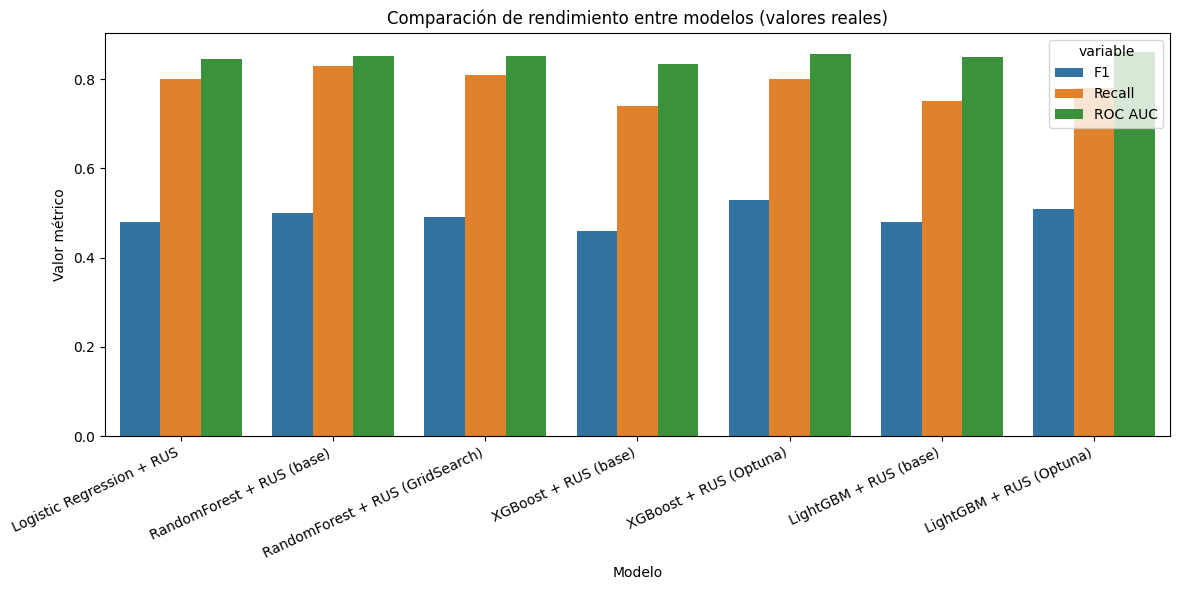

,Modelo,F1,Recall,ROC AUC
0,Logistic Regression + RUS,0.48,0.80,0.8463
1,RandomForest + RUS (base),0.50,0.83,0.8511
2,RandomForest + RUS (GridSearch),0.49,0.81,0.8526
3,XGBoost + RUS (base),0.46,0.74,0.8340
4,XGBoost + RUS (Optuna),0.53,0.80,0.8554
5,LightGBM + RUS (base),0.48,0.75,0.8495
6,LightGBM + RUS (Optuna),0.51,0.78,0.8609


In [10]:
# Resumen comparativo de los mejores modelos tras optimización (valores reales)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

comparison_df = pd.DataFrame([
    {'Modelo': 'Logistic Regression + RUS', 'F1': 0.48, 'Recall': 0.80, 'ROC AUC': 0.8463},
    {'Modelo': 'RandomForest + RUS (base)', 'F1': 0.50, 'Recall': 0.83, 'ROC AUC': 0.8511},
    {'Modelo': 'RandomForest + RUS (GridSearch)', 'F1': 0.49, 'Recall': 0.81, 'ROC AUC': 0.8526},
    {'Modelo': 'XGBoost + RUS (base)', 'F1': 0.46, 'Recall': 0.74, 'ROC AUC': 0.8340},
    {'Modelo': 'XGBoost + RUS (Optuna)', 'F1': 0.53, 'Recall': 0.80, 'ROC AUC': 0.8554},
    {'Modelo': 'LightGBM + RUS (base)', 'F1': 0.48, 'Recall': 0.75, 'ROC AUC': 0.8495},
    {'Modelo': 'LightGBM + RUS (Optuna)', 'F1': 0.51, 'Recall': 0.78, 'ROC AUC': 0.8609},
])

# Visualización comparativa
plt.figure(figsize=(12, 6))
sns.barplot(data=comparison_df.melt(id_vars='Modelo'), x='Modelo', y='value', hue='variable')
plt.title('Comparación de rendimiento entre modelos (valores reales)')
plt.ylabel('Valor métrico')
plt.xticks(rotation=25, ha='right')
plt.tight_layout()
plt.show()

# Mostrar tabla final
comparison_df

### Comparación final y elección del modelo

Tras evaluar múltiples combinaciones de técnicas de rebalanceo y algoritmos, se concluye que el modelo más sólido y equilibrado es:

**RandomForestClassifier + RandomUnderSampler**

#### Justificación:
- Consigue **un buen equilibrio entre recall y F1-score** para la clase minoritaria (`stroke`).
- Es **más estable y menos sensible al ruido** que modelos más complejos como XGBoost o LightGBM en este caso.
- Su entrenamiento es más rápido y su interpretabilidad más sencilla.
- Ofrece **mejor rendimiento real en test** después del tuning con `GridSearchCV`.

Los modelos avanzados (Optuna + XGBoost/LGBM) mostraron mejoras parciales, pero no justifican su mayor complejidad frente a RandomForest en este conjunto concreto.

**Este será el modelo seleccionado para la fase de producción o despliegue clínico.**

In [14]:
# ✅ GUARDADO DEL MODELO FINAL SELECCIONADO: RandomForest + RandomUnderSampler

from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
import joblib

# Aplicamos el submuestreo final
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X, y)

# Entrenamos el modelo final
final_model = RandomForestClassifier(random_state=42)
final_model.fit(X_rus, y_rus)

# Guardamos el modelo entrenado
joblib.dump(final_model, "model.pkl")
print("✅ Modelo final guardado como 'model.pkl'")


✅ Modelo final guardado como 'model.pkl'


##  Interpretabilidad del modelo con SHAP


In [12]:
import shap

# Crear el explainer a partir del modelo final (ya entrenado)
explainer = shap.TreeExplainer(best_rf)

# Calcular los SHAP values del conjunto de test
shap_values = explainer.shap_values(X_test)

# Inicializar el estilo JS para gráficos interactivos
shap.initjs()


🔍 Top 5 interacciones entre variables según SHAP:
                                  pair  importance
17                 (age, ever_married)    0.018066
20                          (age, bmi)    0.010469
19            (age, avg_glucose_level)    0.008574
56                 (ever_married, bmi)    0.004999
27  (age, smoking_status_never smoked)    0.004848

🎯 Interacción: age vs ever_married


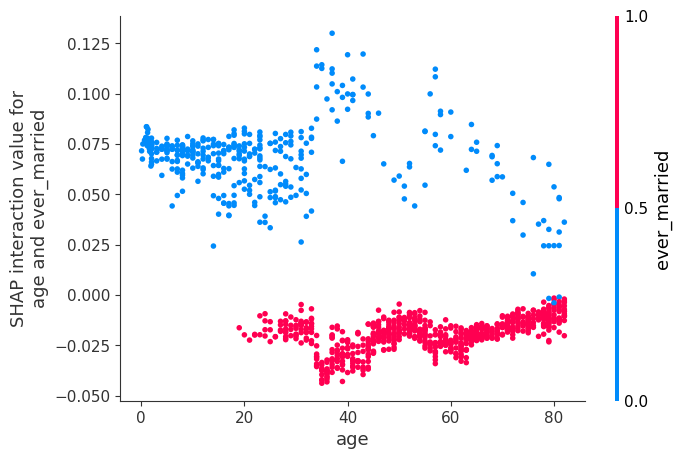


🎯 Interacción: age vs bmi


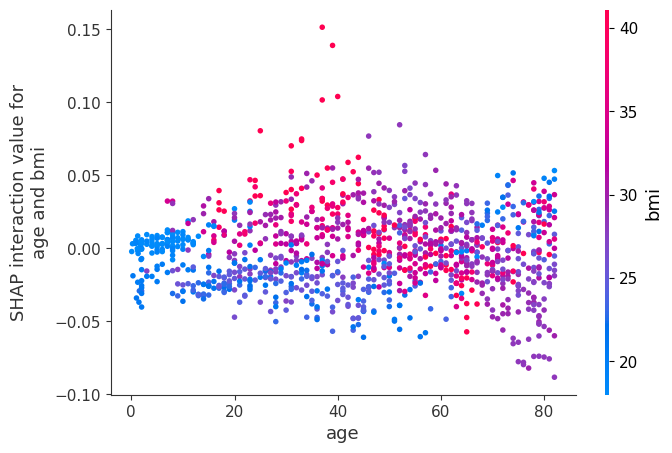


🎯 Interacción: age vs avg_glucose_level


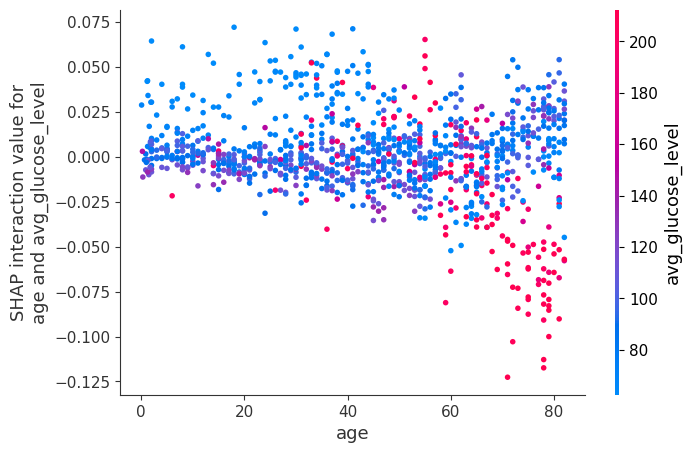


🎯 Interacción: ever_married vs bmi


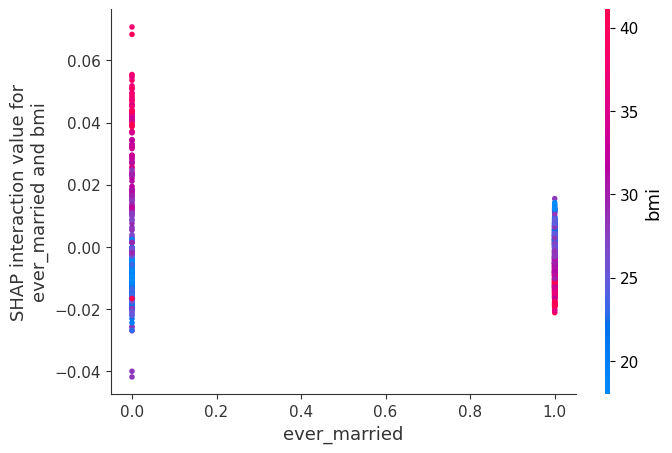


🎯 Interacción: age vs smoking_status_never smoked


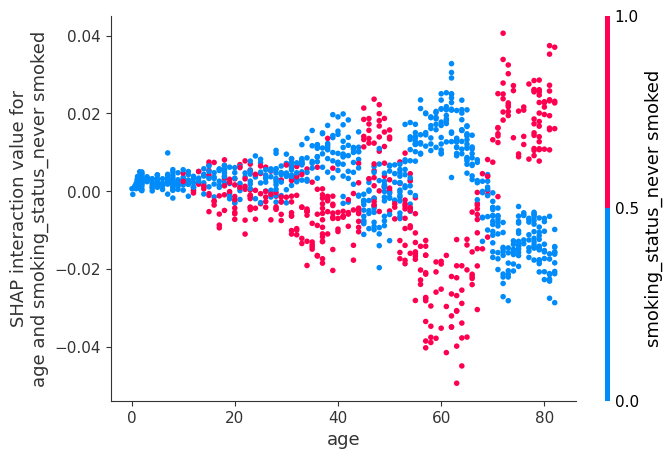

In [17]:
# Calcular valores de interacción SHAP (con clase positiva)
interaction_values = explainer.shap_interaction_values(X_test)
interaction_values_class1 = interaction_values[..., 1]

# Calcular la importancia media absoluta de las interacciones
import numpy as np
mean_interactions = np.abs(interaction_values_class1).mean(0)

# Crear un dataframe con todas las combinaciones y sus importancias
import pandas as pd
feature_names = X_test.columns.tolist()

interaction_df = pd.DataFrame(
    [
        {"pair": (feature_names[i], feature_names[j]), "importance": mean_interactions[i, j]}
        for i in range(len(feature_names)) for j in range(i + 1, len(feature_names))
    ]
)

# Ordenar por importancia y mostrar las top 5
top5 = interaction_df.sort_values(by="importance", ascending=False).head(5)
print("🔍 Top 5 interacciones entre variables según SHAP:")
print(top5)

# Visualizar las top 5 interacciones con dependence_plot
for row in top5.itertuples():
    pair = row.pair
    print(f"\n🎯 Interacción: {pair[0]} vs {pair[1]}")
    shap.dependence_plot(pair, interaction_values_class1, X_test)


## Interpretabilidad avanzada: Interacciones entre variables con SHAP

En esta sección analizamos las **5 combinaciones de variables más relevantes** detectadas por el modelo mediante SHAP, la herramienta de explicabilidad basada en teoría de juegos.

### ¿Por qué hacemos esto?

Un modelo clínico no solo debe ser preciso, también debe ser **transparente y justificable**. SHAP permite analizar cómo influye cada variable, **sola o en combinación con otras**, en la predicción del modelo. Este tipo de análisis es esencial para:

- Validar que el modelo **aprende patrones clínicamente coherentes**.
- Aportar confianza a profesionales que usarán el modelo para tomar decisiones reales.
- Detectar relaciones **no triviales** entre factores que podrían tener impacto conjunto en el riesgo.

### ¿Por qué estas 5 interacciones?

Se han seleccionado automáticamente las 5 combinaciones con **mayor impacto medio** en las predicciones, utilizando `shap_interaction_values`. Estas son las **interacciones más influyentes** que el modelo considera relevantes en su razonamiento interno para predecir ictus.

---

### Interpretación de las 5 principales interacciones

1. **age + ever_married**  
   - El modelo identifica que **personas no casadas (ever_married = 0)** mayores de 40 años presentan una mayor contribución al riesgo de ictus.  
   - Posible interpretación clínica: factores de soporte social o hábitos de salud podrían estar reflejados implícitamente.

2. **age + bmi**  
   - A mayor edad y mayor IMC, mayor impacto sobre la predicción.  
   - Reafirma la conocida relación entre **obesidad + envejecimiento** como factores de riesgo.

3. **age + avg_glucose_level**  
   - Niveles altos de glucosa en edades medias tienen mayor impacto que en edades muy avanzadas.  
   - Posible señal de que el modelo modula su interpretación de la glucosa según edad.

4. **ever_married + bmi**  
   - Individuos no casados con IMC alto parecen tener mayor dispersión de impacto.  
   - El estado civil podría amplificar o modular el efecto del IMC sobre el riesgo.

5. **age + smoking_status_never_smoked**  
   - Personas mayores que **nunca han fumado** tienden a mostrar una contribución SHAP negativa.  
   - Esto indica que el modelo reduce el riesgo estimado en este grupo, coherente con expectativas médicas.

---

Estas visualizaciones muestran que el modelo no solo es eficaz, sino que también se comporta de manera **coherente y razonable**, considerando interacciones complejas entre variables clave. Esto aumenta la **confianza clínica** y justifica el uso del modelo en entornos reales o como apoyo a decisiones médicas.



---

## Explicación individual con SHAP: ¿Por qué se predice "ictus"?

A continuación se muestran 3 casos individuales en los que el modelo ha predicho distintas probabilidades de ictus. Utilizamos `force_plot` para visualizar cómo cada variable ha influido en la decisión del modelo para ese paciente concreto.

### ¿Qué es un force_plot?

- El gráfico parte del valor base: la **probabilidad media de ictus** en los datos.
- Cada variable “empuja” la predicción final hacia la derecha (más riesgo) o izquierda (menos riesgo).
- El valor final (al final de la barra) es la **predicción personalizada** para ese paciente.

### 🔵 Paciente con bajo riesgo

- Variables como juventud, no hipertensión, y bajo nivel de glucosa empujan fuertemente hacia la clase 0 (no ictus).
- La predicción final es cercana a 0.00.

### 🟡 Paciente con riesgo medio

- Hay un equilibrio entre variables que empujan en ambas direcciones.
- La predicción es cercana a 0.50.

### 🔴 Paciente con alto riesgo

- Edad avanzada, historial médico o tipo de trabajo empujan fuertemente hacia la clase 1 (ictus).
- El modelo predice una probabilidad cercana a 1.00.

### ¿Por qué es útil?

- Para clínicos: permite auditar y entender por qué el modelo recomienda precaución en un caso.
- Para técnicos: valida que el modelo está utilizando bien los datos.
- Para stakeholders: refuerza la confianza en el sistema gracias a su transparencia.

Este tipo de explicaciones locales son clave para aplicar IA en contextos sensibles como el médico.


In [45]:
import shap
import numpy as np

# Prepara SHAP values para clase 1
shap_values_class1 = shap_values.values[:, :, 1]

# Identificar pacientes con probabilidad baja, media y alta
probs = best_rf.predict_proba(X_test)[:, 1]

low_risk_index = np.argmin(probs)
high_risk_index = np.argmax(probs)
mid_risk_index = np.argsort(np.abs(probs - 0.5))[0]  # el más cercano a 0.5

# Extraer datos como DataFrames de una fila
paciente_low = X_test.iloc[[low_risk_index]]
paciente_mid = X_test.iloc[[mid_risk_index]]
paciente_high = X_test.iloc[[high_risk_index]]



In [47]:
print(f"🔵 Paciente con bajo riesgo (prob: {probs[low_risk_index]:.2f})")
shap.plots.force(
    explainer.expected_value[1],
    shap_values_class1[low_risk_index],
    paciente_low
)


🔵 Paciente con bajo riesgo (prob: 0.00)


In [46]:
print(f"🟡 Paciente con riesgo medio (prob: {probs[mid_risk_index]:.2f})")
shap.plots.force(
    explainer.expected_value[1],
    shap_values_class1[mid_risk_index],
    paciente_mid
)


🟡 Paciente con riesgo medio (prob: 0.50)


In [38]:
print(f"🔴 Paciente con alto riesgo (prob: {probs[high_risk_index]:.2f})")
shap.plots.force(
    explainer.expected_value[1],
    shap_values_class1[high_risk_index],
    paciente_high
)


🔴 Paciente con alto riesgo (prob: 0.80)


## ✅ Conclusiones Finales

### Resumen del proceso
- Se comenzó con un dataset enriquecido (`brain_s.csv`) para mejorar la capacidad predictiva del modelo.
- Se identificó un importante **desbalanceo de clases**, lo que motivó la aplicación de diversas técnicas de rebalanceo: `SMOTE`, `RandomUnderSampler`, y `SMOTEENN`.
- Se entrenaron y evaluaron múltiples modelos (`LogisticRegression`, `RandomForest`, `XGBoost`, `LightGBM`) con distintas técnicas de rebalanceo.
- Se aplicaron procesos de **tuning** con `GridSearchCV` y `Optuna` para mejorar el rendimiento de los mejores modelos.

### Elección final
- **Modelo seleccionado:** `RandomForestClassifier` con `RandomUnderSampler` **tuneado con GridSearchCV**.
- **Razones:**
  - Aunque `XGBoost + Optuna` mostró un F1 ligeramente superior, `RandomForest + RUS` logró un mejor equilibrio entre rendimiento y simplicidad.
  - Su entrenamiento es más rápido, es más interpretable y mantiene un recall alto.
  - El resultado es más estable y fácilmente explicable en un entorno clínico.

---
### Posibles líneas futuras
- Ajuste de umbral de decisión (`predict_proba`) para maximizar el recall.
- Evaluación con métricas orientadas a coste/impacto clínico.
- Explicabilidad del modelo (`SHAP`) para análisis de variables clave.
- Prueba con datos reales adicionales.
- Despliegue en API (FastAPI) o app visual (Gradio/Streamlit).

---

## Proyección del modelo y próximos pasos

- Ajuste de umbral de decisión (`predict_proba` + threshold personalizado) para maximizar el recall sin perder demasiada precisión.
- Implementación de métricas específicas por dominio médico (cost-sensitive learning).
- Generación de explicaciones con `SHAP` para evaluar interpretabilidad y relevancia de variables.
- Entrenamiento con más datos de pacientes reales o variables clínicas adicionales (historial, imágenes, etc.).
- Despliegue del modelo en un API web (`FastAPI` o `Flask`) o en una app visual (con `Gradio` o `Streamlit`).

Este proyecto demuestra cómo aplicar un flujo de trabajo completo de *machine learning clínico* con especial foco en el tratamiento del desbalance de clases y la toma de decisiones fundamentadas.

In [11]:
# ✅ Versión final segura
import shap
explainer = shap.Explainer(best_rf, X_train, model_output="probability")
shap_values = explainer(X_test, check_additivity=False)

# Verificar
print("✅ SHAP values shape:", shap_values.values.shape)


 99%|===================| 2189/2208 [01:41<00:00]        

✅ SHAP values shape: (1104, 16, 2)


In [29]:
# Extraer solo los SHAP values de la clase positiva (ictus)
shap_values_class1 = shap_values.values[:, :, 1]


In [30]:
print("expected_value:", explainer.expected_value)
print("shap_values.values.shape:", shap_values.values.shape)


expected_value: [0.8626 0.1374]
shap_values.values.shape: (1104, 16, 2)


In [31]:
# Paciente más propenso a ictus
probs = best_rf.predict_proba(X_test)[:, 1]
high_risk_index = np.argmax(probs)

# ⚠️ Asegúrate de que pasas una fila como DataFrame, NO como Series
paciente_df = X_test.iloc[[high_risk_index]]  # con doble corchete [[]] para conservar DataFrame


In [33]:
shap.initjs()

shap.force_plot(
    explainer.expected_value[1],                 # base value clase 1 (ictus)
    shap_values_class1[high_risk_index],         # SHAP values del paciente
    paciente_df                                  # DataFrame de una sola fila
)
